# Traffic sign detection with SSD

In [1]:
import time
import numpy as np
import cv2
import csv
import glob
import random
import matplotlib as mpl
import matplotlib.pyplot as plt

import mxnet as mx
import mxnet.image as image
from mxnet import nd
from mxnet.gluon import nn
from mxnet import gluon
from mxnet.contrib.ndarray import MultiBoxTarget
from mxnet.contrib.ndarray import MultiBoxPrior
from mxnet.contrib.ndarray import MultiBoxDetection

print("all module imported")

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


all module imported


# Load Data

### Load Image

In [2]:
NUM_CLASS = 43
BATCH_SIZE = 16
DATA_SHAPE = 256

train_data = mx.image.ImageIter(
   batch_size=BATCH_SIZE, label_width = 1,
   data_shape=(3, DATA_SHAPE, DATA_SHAPE), 
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)

test_data = mx.image.ImageIter(  
   batch_size=BATCH_SIZE, label_width = 1,
   data_shape=(3, DATA_SHAPE, DATA_SHAPE),  
   path_imgrec='./dataset/dataset.rec',  
   path_imgidx='./dataset/dataset.idx',  #help shuffle performance
   shuffle=True)

batch = train_data.next()

### Load Label

In [3]:
paths = glob.glob("dataset/scene-jpg/*.jpg")
labels = nd.zeros((len(paths), NUM_CLASS+1, 5)) -1.
print(labels.shape)
gts = open("dataset/gt1.txt",'r').read().split('\n')[:-1]
for gt in gts:
    line = gt.split(";")
    idx = int(line[0].split(".")[0])
    minx = float(line[1])
    miny = float(line[2])
    maxx = float(line[3])
    maxy = float(line[4])
    label = float(line[5])
    labels[idx][int(label)] = [label, minx, miny, maxx, maxy]
print(len(paths), len(gts), len(labels))
print(labels[1])

(900, 44, 5)
900 1213 900

[[-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [13.      0.7154  0.4188  0.7581  0.4875]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -

### Load sign names

In [4]:
signname_file = "dataset/signnames.csv"
with open(signname_file) as f:
    f.readline() # skip the headers
    signnames = [row[1] for row in csv.reader(f)]
print(signnames)

['Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)', 'No passing', 'No passing for vehicles over 3.5 metric tons', 'Right-of-way at the next intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited', 'No entry', 'General caution', 'Dangerous curve to the left', 'Dangerous curve to the right', 'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing', 'End of all speed and passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 'Keep left', 'Roundabout mandatory', 'End of no passing', 'End of no passing by vehicles over 3.5 metric tons']


### Show example

In [5]:
%matplotlib inline
batch_label = batch.label[0].asnumpy().astype(int)
print(batch_label)
img = batch.data[0][0]
img = img.transpose((1, 2, 0))
img = img.clip(0,255).asnumpy()/255
mul_label = labels[batch_label][0].asnumpy()
# print(mul_label)

[445 546 772 861 801 825 792 409 280 352  28 308 286 457 860 671]


445
5 Speed limit (80km/h) 40 166 47 179
546
772
18 General caution 158 176 162 183
861


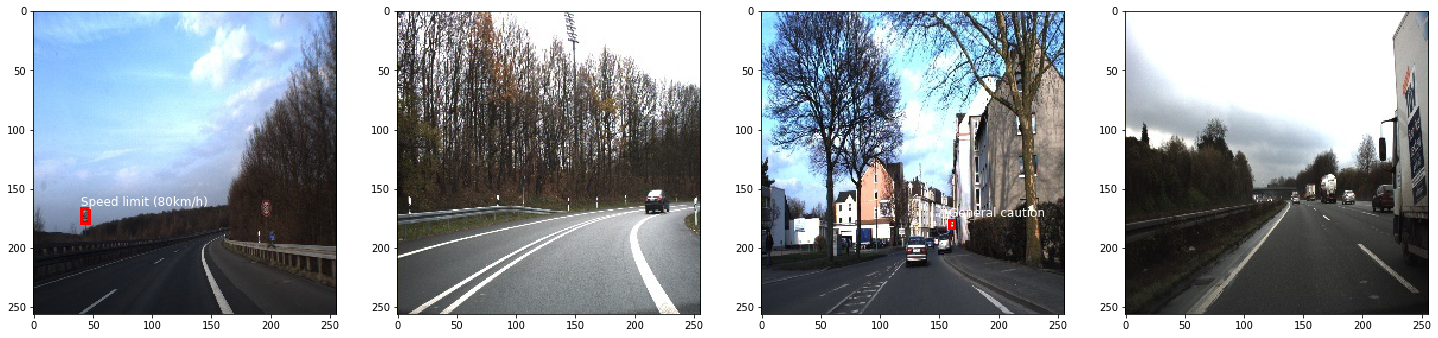

In [6]:
fig,ax = plt.subplots(1, 4, figsize=(25,25))
for i in range(4):
    print(batch_label[i])
    img = batch.data[0][i]
    img = img.transpose((1, 2, 0))
    img = img.clip(0,255).asnumpy() / 255
    mul_label = labels[batch_label][i].asnumpy()
    ax[i].imshow(img)
    for box in mul_label:
        sign = int(box[0])
        if(sign < 0):
            continue
        minx = int(box[1] * DATA_SHAPE)
        miny = int(box[2] * DATA_SHAPE)
        maxx = int(box[3] * DATA_SHAPE)
        maxy = int(box[4] * DATA_SHAPE)
        print(sign, signnames[sign], minx, miny, maxx, maxy)
        rect = plt.Rectangle((minx, miny), maxx-minx, maxy-miny,fill=False, edgecolor='red', linewidth=3)
        ax[i].add_patch(rect)
        ax[i].text(minx, miny-2, '{:s}'.format(signnames[sign]),fontsize=12, color='white')
plt.show()

# SSD Detector

The first anchor box at row 21, column 21: 
[[0.29257813 0.29257813 0.49257812 0.49257812]
 [0.31757814 0.31757814 0.4675781  0.4675781 ]
 [0.3425781  0.3425781  0.44257814 0.44257814]
 [0.25115675 0.32186744 0.5339995  0.4632888 ]
 [0.32186744 0.25115675 0.4632888  0.5339995 ]]
<NDArray 5x4 @cpu(0)>


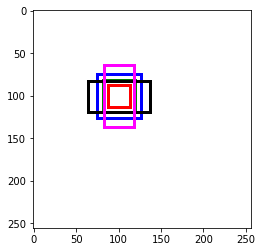

In [7]:
n = 256
# shape: batch x channel x height x weight
x = nd.random_uniform(shape=(1, 3, n, n))  

y = MultiBoxPrior(x, sizes=[.2, .15, .1], ratios=[1, 2, .5])

# the first anchor box generated for pixel at (20,20)
# its format is (x_min, y_min, x_max, y_max)
boxes = y.reshape((n, n, -1, 4))
print('The first anchor box at row 21, column 21:', boxes[100, 100, :, :])

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), (box[2]-box[0]), (box[3]-box[1]), 
        fill=False, edgecolor=color, linewidth=linewidth)
colors = ['blue', 'green', 'red', 'black', 'magenta']
plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[100, 100, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:]*n, colors[i]))
plt.show()

In [8]:
def class_predictor(num_anchors, num_classes):
    """return a layer to predict classes"""
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding=1)

cls_pred = class_predictor(5, NUM_CLASS)
cls_pred.initialize()
x = nd.zeros((BATCH_SIZE, 3, DATA_SHAPE, DATA_SHAPE))
print('Class prediction', cls_pred(x).shape)

Class prediction (16, 220, 256, 256)


In [9]:
def box_predictor(num_anchors):
    """return a layer to predict delta locations"""
    return nn.Conv2D(num_anchors * 4, 3, padding=1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((BATCH_SIZE, 3, DATA_SHAPE, DATA_SHAPE))
print('Box prediction', box_pred(x).shape)

Box prediction (16, 40, 256, 256)


In [10]:
def down_sample(num_filters):
    """stack two Conv-BatchNorm-Relu blocks and then a pooling layer 
    to halve the feature size"""
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides=1, padding=1))
        out.add(nn.BatchNorm(in_channels=num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((BATCH_SIZE, 3, DATA_SHAPE, DATA_SHAPE))
print('Before', x.shape, 'after', blk(x).shape)

Before (16, 3, 256, 256) after (16, 10, 128, 128)


In [11]:
feat1 = nd.zeros((BATCH_SIZE, 8, DATA_SHAPE, DATA_SHAPE))
print('Feature map 1', feat1.shape)
cls_pred1 = class_predictor(5, NUM_CLASS)
cls_pred1.initialize()
y1 = cls_pred1(feat1)
print('Class prediction for feature map 1', y1.shape)
# down-sample 
ds = down_sample(16)
ds.initialize()
feat2 = ds(feat1)
print('Feature map 2', feat2.shape)
cls_pred2 = class_predictor(3, NUM_CLASS)
cls_pred2.initialize()
y2 = cls_pred2(feat2)
print('Class prediction for feature map 2', y2.shape)

Feature map 1 (16, 8, 256, 256)
Class prediction for feature map 1 (16, 220, 256, 256)
Feature map 2 (16, 16, 128, 128)
Class prediction for feature map 2 (16, 132, 128, 128)


In [12]:
def flatten_prediction(pred):
    return nd.flatten(nd.transpose(pred, axes=(0, 2, 3, 1)))

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
print('Concat class predictions', concat_predictions([flat_y1, flat_y2]).shape)

Flatten class prediction 1 (16, 14417920)
Flatten class prediction 2 (16, 2162688)
Concat class predictions (16, 16580608)


In [13]:
def body():
    """return the body network"""
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.zeros((BATCH_SIZE, 3, DATA_SHAPE, DATA_SHAPE))
print('Body network', [y.shape for y in bnet(x)])

Body network [(64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32), (64, 32, 32)]


In [14]:
def toy_ssd_model(num_anchors, num_classes):
    """return SSD modules"""
    downsamples = nn.Sequential()
    class_preds = nn.Sequential()
    box_preds = nn.Sequential()

    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    downsamples.add(down_sample(128))
    
    for scale in range(5):
        class_preds.add(class_predictor(num_anchors, num_classes))
        box_preds.add(box_predictor(num_anchors))
    
    return body(), downsamples, class_preds, box_preds

print(toy_ssd_model(5, NUM_CLASS))

(HybridSequential(
  (0): HybridSequential(
    (0): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(fix_gamma=False, eps=1e-05, axis=1, use_global_stats=False, momentum=0.9, in_channels=16)
    (2): Activation(relu)
    (3): Conv2D(None -> 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(fix_gamma=False, eps=1e-05, axis=1, use_global_stats=False, momentum=0.9, in_channels=16)
    (5): Activation(relu)
    (6): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
  )
  (1): HybridSequential(
    (0): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm(fix_gamma=False, eps=1e-05, axis=1, use_global_stats=False, momentum=0.9, in_channels=32)
    (2): Activation(relu)
    (3): Conv2D(None -> 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm(fix_gamma=False, eps=1e-05, axis=1, use_global_stats=False, momentum=0.9, in_channels=32)
    (5): Activati

In [15]:
def toy_ssd_forward(x, body, downsamples, class_preds, box_preds, sizes, ratios):                
    # extract feature with the body network        
    x = body(x)
        
    # for each scale, add anchors, box and class predictions,
    # then compute the input to next scale 
    default_anchors = []
    predicted_boxes = []  
    predicted_classes = []
                        
    for i in range(5):
        default_anchors.append(MultiBoxPrior(x, sizes=sizes[i], ratios=ratios[i]))
        predicted_boxes.append(flatten_prediction(box_preds[i](x)))
        predicted_classes.append(flatten_prediction(class_preds[i](x)))
        if i < 3:
            x = downsamples[i](x)
        elif i == 3:
            # simply use the pooling layer
            x = nd.Pooling(x, global_pool=True, pool_type='max', kernel=(4, 4))

    return default_anchors, predicted_classes, predicted_boxes

In [30]:
class ToySSD(gluon.Block):
    def __init__(self, num_classes, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes for 4 feature scales
        self.anchor_sizes = [[.05, .06], [.8, .1], [.12, .14], [.15, .17], [.18, .2]]
        # anchor box ratios for 4 feature scales
        self.anchor_ratios = [[1, 2, .5]] * 5
        self.num_classes = num_classes

        with self.name_scope():
            self.body, self.downsamples, self.class_preds, self.box_preds = toy_ssd_model(4, num_classes)
            
    def forward(self, x):
        default_anchors, predicted_classes, predicted_boxes = toy_ssd_forward(x, self.body, self.downsamples,
            self.class_preds, self.box_preds, self.anchor_sizes, self.anchor_ratios)
        # we want to concatenate anchors, class predictions, box predictions from different layers
        anchors = concat_predictions(default_anchors)
        box_preds = concat_predictions(predicted_boxes)
        class_preds = concat_predictions(predicted_classes)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = nd.reshape(class_preds, shape=(0, -1, self.num_classes + 1))
        
        return anchors, class_preds, box_preds

# Train

In [75]:
def training_targets(default_anchors, class_predicts, labels):
    class_predicts = nd.transpose(class_predicts, axes=(0, 2, 1))
    z = MultiBoxTarget(*[default_anchors, labels, class_predicts])
    box_target = z[0]  # box offset target for (x, y, width, height)
    box_mask = z[1]  # mask is used to ignore box offsets we don't want to penalize, e.g. negative samples
    cls_target = z[2]  # cls_target is an array of labels for all anchors boxes
    return box_target, box_mask, cls_target

In [76]:
class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma
    
    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pt = F.pick(output, label, axis=self._axis, keepdims=True)
        loss = -self._alpha * ((1 - pt) ** self._gamma) * F.log(pt)
        return F.mean(loss, axis=self._batch_axis, exclude=True)

# cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
cls_loss = FocalLoss()
print(cls_loss)

FocalLoss(batch_axis=0, w=None)


In [77]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)
    
    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return F.mean(loss, self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
print(box_loss)

SmoothL1Loss(batch_axis=0, w=None)


In [78]:
cls_metric = mx.metric.Accuracy()
box_metric = mx.metric.MAE()

In [79]:
### Set context for training
ctx = mx.gpu()  # it may takes too long to train using CPU
_ = nd.zeros(1, ctx=ctx)
# pad label for cuda implementation
# train_data.reshape(label_shape=(NUM_CLASS + 1, 5))
# train_data = test_data.sync_label_shape(train_data)
# print(labels)
# labels = nd.array(labels)

In [80]:
net = ToySSD(NUM_CLASS)
net.initialize(mx.init.Xavier(magnitude=2), ctx=ctx)
print(net.num_classes)
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

43


In [81]:
log_interval = 20
start_epoch = 0
epochs = 50

In [82]:
from mxnet import autograd as ag
for epoch in range(start_epoch, epochs):
    # reset iterator and tick
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    # iterate through all batch
    for i, batch in enumerate(train_data):
        btic = time.time()
        # record gradients
        with ag.record():
            x = batch.data[0].as_in_context(ctx) - 128.
            batch_label = batch.label[0].asnumpy().astype(int)
            y = labels[batch_label].as_in_context(ctx)
            default_anchors, class_predictions, box_predictions = net(x)
            box_target, box_mask, cls_target = training_targets(default_anchors, class_predictions, y)
            # losses
            loss1 = cls_loss(class_predictions, cls_target)
            loss2 = box_loss(box_predictions, box_target, box_mask)
            # sum all losses
            loss = loss1 + loss2
            # backpropagate
            loss.backward()
        # apply 
        trainer.step(BATCH_SIZE)
        # update metrics
        cls_metric.update([cls_target], [nd.transpose(class_predictions, (0, 2, 1))])
        box_metric.update([box_target], [box_predictions * box_mask])
        if (i + 1) % log_interval == 0:
            name1, val1 = cls_metric.get()
            name2, val2 = box_metric.get()
            print('[Epoch %d Batch %d] speed: %f samples/s, training: %s=%f, %s=%f' 
                  %(epoch ,i, BATCH_SIZE/(time.time()-btic), name1, val1, name2, val2))
    
    # end of epoch logging
    name1, val1 = cls_metric.get()
    name2, val2 = box_metric.get()
    print('[Epoch %d] training: %s=%f, %s=%f'%(epoch, name1, val1, name2, val2))
    print('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
    
# we can save the trained parameters to disk
net.save_params('ssd_%d.params' % epochs)

MXNetError: [07:58:50] src/storage/./pooled_storage_manager.h:108: cudaMalloc failed: out of memory

Stack trace returned 10 entries:
[bt] (0) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x322542) [0x7f6b8d5ce542]
[bt] (1) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x322b18) [0x7f6b8d5ceb18]
[bt] (2) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x2df550f) [0x7f6b900a150f]
[bt] (3) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x2df9b1c) [0x7f6b900a5b1c]
[bt] (4) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x46cbeb) [0x7f6b8d718beb]
[bt] (5) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x293b599) [0x7f6b8fbe7599]
[bt] (6) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x293ba38) [0x7f6b8fbe7a38]
[bt] (7) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x28b6198) [0x7f6b8fb62198]
[bt] (8) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x28b6213) [0x7f6b8fb62213]
[bt] (9) /usr/local/lib/python3.5/dist-packages/mxnet/libmxnet.so(+0x28be204) [0x7f6b8fb6a204]



# Test

In [23]:
def preprocess(image):
    """Takes an image and apply preprocess"""
    # swap BGR to RGB
    image = image[:, :, (2, 1, 0)]
    # convert to float before subtracting mean
    image = image.astype(np.float32)
    # subtract mean
    image -= 128.
    # organize as [batch-channel-height-width]
    image = np.transpose(image, (2, 0, 1))
    image = image[np.newaxis, :]
    # convert to ndarray
    image = nd.array(image)
    return image

index = random.randint(0, len(labels))
image = cv2.imread('dataset/scene-jpg/'+ str(index).zfill(5) +'.jpg')
x = preprocess(image)
print(index, image.shape, x.shape)

117 (256, 256, 3) (1, 3, 256, 256)


In [31]:
net = ToySSD(NUM_CLASS)
net.load_params('ssd_30.params')
anchors, cls_preds, box_preds = net(x)
print('anchors', anchors)
print('class predictions', cls_preds)
print('box delta predictions', box_preds)

anchors 
[[[-0.009375   -0.009375    0.040625    0.040625  ]
  [-0.014375   -0.014375    0.045625    0.045625  ]
  [-0.01973034 -0.00205267  0.05098034  0.03330267]
  ...
  [ 0.4         0.4         0.6         0.6       ]
  [ 0.37272078  0.4363604   0.6272792   0.56363964]
  [ 0.4363604   0.37272078  0.56363964  0.6272792 ]]]
<NDArray 1x5444x4 @cpu(0)>
class predictions 
[[[ 6.1132994   0.06779509 -0.2961949  ...  0.68562496 -0.09492029
    0.48052478]
  [ 6.3329926  -0.5604779   0.2595053  ... -0.4739199  -0.5963611
   -0.10293763]
  [ 5.936318    0.07021934  0.458778   ...  0.8100515  -0.31149557
   -0.21212228]
  ...
  [ 3.807493   -0.20577058 -0.5614947  ... -0.05966656  0.09273689
   -0.41490057]
  [ 3.7680724   0.2883078  -0.0633566  ...  0.8520621  -0.60578763
    0.10814538]
  [ 3.6381452   0.30702937  0.7505089  ... -0.38755187  0.33755204
    0.26285854]]]
<NDArray 1x5444x44 @cpu(0)>
box delta predictions 
[[-0.7691389   0.11715335  0.42957357 ...  0.30315772  0.6004491
   0

In [32]:
# convert predictions to probabilities using softmax
cls_probs = nd.SoftmaxActivation(nd.transpose(cls_preds, (0, 2, 1)), mode='channel')
# apply shifts to anchors boxes, non-maximum-suppression, etc...
output = MultiBoxDetection(*[cls_probs, box_preds, anchors], force_suppress=True, clip=False)
print(output[0])


[[19.          0.03570351  0.02726588  0.8615863   0.11762732  1.0398836 ]
 [ 4.          0.03399655  0.4034067   0.40249252  0.648319    0.59789073]
 [ 5.          0.02887099  0.4289152   0.37569535  0.5724351   0.6397389 ]
 ...
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.        ]]
<NDArray 5444x6 @cpu(0)>



[[-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [17.      0.0728  0.5312  0.0963  0.5825]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     -1.     -1.     -1.     -1.    ]
 [-1.     

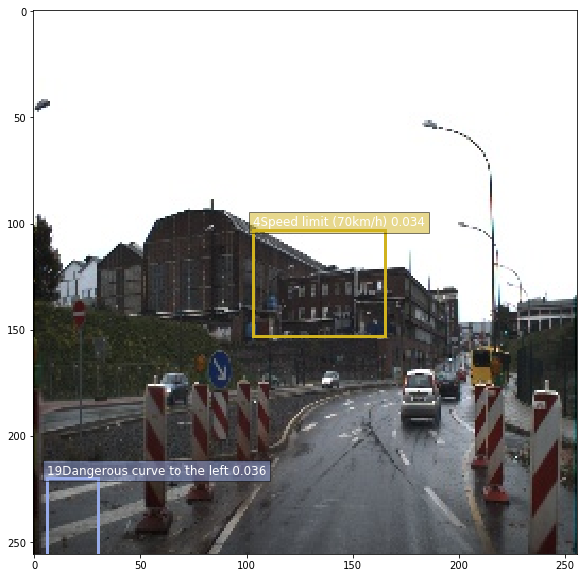

In [33]:
def display(img, out, thresh=0.5):
    mpl.rcParams['figure.figsize'] = (10,10)
    pens = dict()
    plt.clf()
    plt.imshow(img)
    for det in out:
        cid = int(det[0])
        if cid < 0:
            continue
        score = det[1]
        if score < thresh:
            continue
        if cid not in pens:
            pens[cid] = (random.random(), random.random(), random.random())
        scales = [img.shape[1], img.shape[0]] * 2
        xmin, ymin, xmax, ymax = [int(p * s) for p, s in zip(det[2:6].clip(0,1).tolist(), scales)]
        rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, 
                             edgecolor=pens[cid], linewidth=3)
        plt.gca().add_patch(rect)
        text = signnames[cid]
        plt.gca().text(xmin, ymin-2, '{:d}{:s} {:.3f}'.format(cid, text, score),
                       bbox=dict(facecolor=pens[cid], alpha=0.5),
                       fontsize=12, color='white')
    plt.show()
    
print(labels[index])
display(image[:, :, (2, 1, 0)], output[0].asnumpy(), thresh=0.03)